## Import

In [2]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

## Fixed Random Seed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

## Data Load

In [4]:
base_path = "/home/jinjinjara1022/"

weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_1.csv")
weather_forecast_data_2 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_2.csv")  

weather_observed_data_1 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_1.csv")
weather_observed_data_2 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_2.csv")  
  
jeju_power_market_day_ahead = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_하루전가격.csv")
jeju_power_market_real_time = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_실시간가격.csv")

jeju_power_market_status = pd.read_csv(base_path + "OBIC/data/제주전력시장_현황데이터.csv")

## Data preprocessing

In [5]:
df = jeju_power_market_day_ahead

In [6]:
df['datetimes'] = pd.to_datetime(df['ts'], unit='s')

# 3. 월, 일, 시각 열 추가
df['month'] = df['datetimes'].dt.month
df['day'] = df['datetimes'].dt.day
df['hour'] = df['datetimes'].dt.hour

df = df[[col for col in df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]

In [7]:
df = df.drop(['ts', 'datetimes', 'month', 'day'], axis=1)

In [8]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

In [9]:
df = df.drop(['hour'], axis=1)

In [10]:
df = df[[col for col in df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]

In [11]:
train_df = df[:int(len(df) * 0.8)]
vali_df = df[int(len(df) * 0.8):]

In [12]:
train_df

,hour_sin,hour_cos,하루전가격(원/kWh)
0,-0.707107,-7.071068e-01,107.39
1,-0.866025,-5.000000e-01,107.39
2,-0.965926,-2.588190e-01,95.30
3,-1.000000,-1.836970e-16,87.89
4,-0.965926,2.588190e-01,0.00
...,...,...,...
4527,1.000000,6.123234e-17,150.69
4528,0.965926,-2.588190e-01,152.93
4529,0.866025,-5.000000e-01,152.93
4530,0.707107,-7.071068e-01,160.70


In [13]:
input_size = 3  # feature의 개수
hidden_size = 32
num_layers = 2
output_size = 1
num_epochs = 100
window_size = 48  # 예측에 사용될 시간 윈도우 크기
batch_size = 32
learning_rate = 0.001

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size):
        self.df = df.values
        self.window_size = window_size

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = torch.tensor(self.df[idx:idx+self.window_size, :], dtype=torch.float)
        y = torch.tensor(self.df[idx+self.window_size, -1], dtype=torch.float)  # 예측할 열이 마지막 열에 있다고 가정
        return x, y

def create_data_loader(df, window_size, batch_size):
    dataset = TimeSeriesDataset(df, window_size)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_loader


train_loader = create_data_loader(train_df, window_size, batch_size)

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"current device: {device}")

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

current device: cuda


In [17]:
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        
        
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/100], Step [141/141], Loss: 22173.6133
Epoch [2/100], Step [141/141], Loss: 20653.0586
Epoch [3/100], Step [141/141], Loss: 19320.3281
Epoch [4/100], Step [141/141], Loss: 18090.4180
Epoch [5/100], Step [141/141], Loss: 16939.6074
Epoch [6/100], Step [141/141], Loss: 15856.7051
Epoch [7/100], Step [141/141], Loss: 14828.8066
Epoch [8/100], Step [141/141], Loss: 13851.0820
Epoch [9/100], Step [141/141], Loss: 12922.8096
Epoch [10/100], Step [141/141], Loss: 12042.7412
Epoch [11/100], Step [141/141], Loss: 11210.0322
Epoch [12/100], Step [141/141], Loss: 10422.5732
Epoch [13/100], Step [141/141], Loss: 9678.3867
Epoch [14/100], Step [141/141], Loss: 8975.0488
Epoch [15/100], Step [141/141], Loss: 8311.7852
Epoch [16/100], Step [141/141], Loss: 7686.5952
Epoch [17/100], Step [141/141], Loss: 7098.4346
Epoch [18/100], Step [141/141], Loss: 6545.8447
Epoch [19/100], Step [141/141], Loss: 6026.7017
Epoch [20/100], Step [141/141], Loss: 5540.8413
Epoch [21/100], Step [141/141], Loss:

In [18]:
vali_df

,hour_sin,hour_cos,하루전가격(원/kWh)
4532,2.588190e-01,-0.965926,161.03
4533,1.224647e-16,-1.000000,161.03
4534,-2.588190e-01,-0.965926,161.03
4535,-5.000000e-01,-0.866025,161.03
4536,-7.071068e-01,-0.707107,140.15
...,...,...,...
5660,2.588190e-01,-0.965926,156.68
5661,1.224647e-16,-1.000000,152.54
5662,-2.588190e-01,-0.965926,106.92
5663,-5.000000e-01,-0.866025,150.97


In [32]:
test_loader = create_data_loader(df, window_size, 1)

In [37]:
real = []
preds = []
pred = None

model.to('cpu')

for idx, (X, y) in enumerate(test_loader):
    if pred:
        inputs = X
        inputs[0][-1][-1] = pred
        outputs = model(inputs)
    else:
        inputs = X
        outputs = model(inputs)
    
    pred = float(outputs)
    y = float(y)

    real.append(y)
    preds.append(pred)
    
    if idx == 1000:
        break

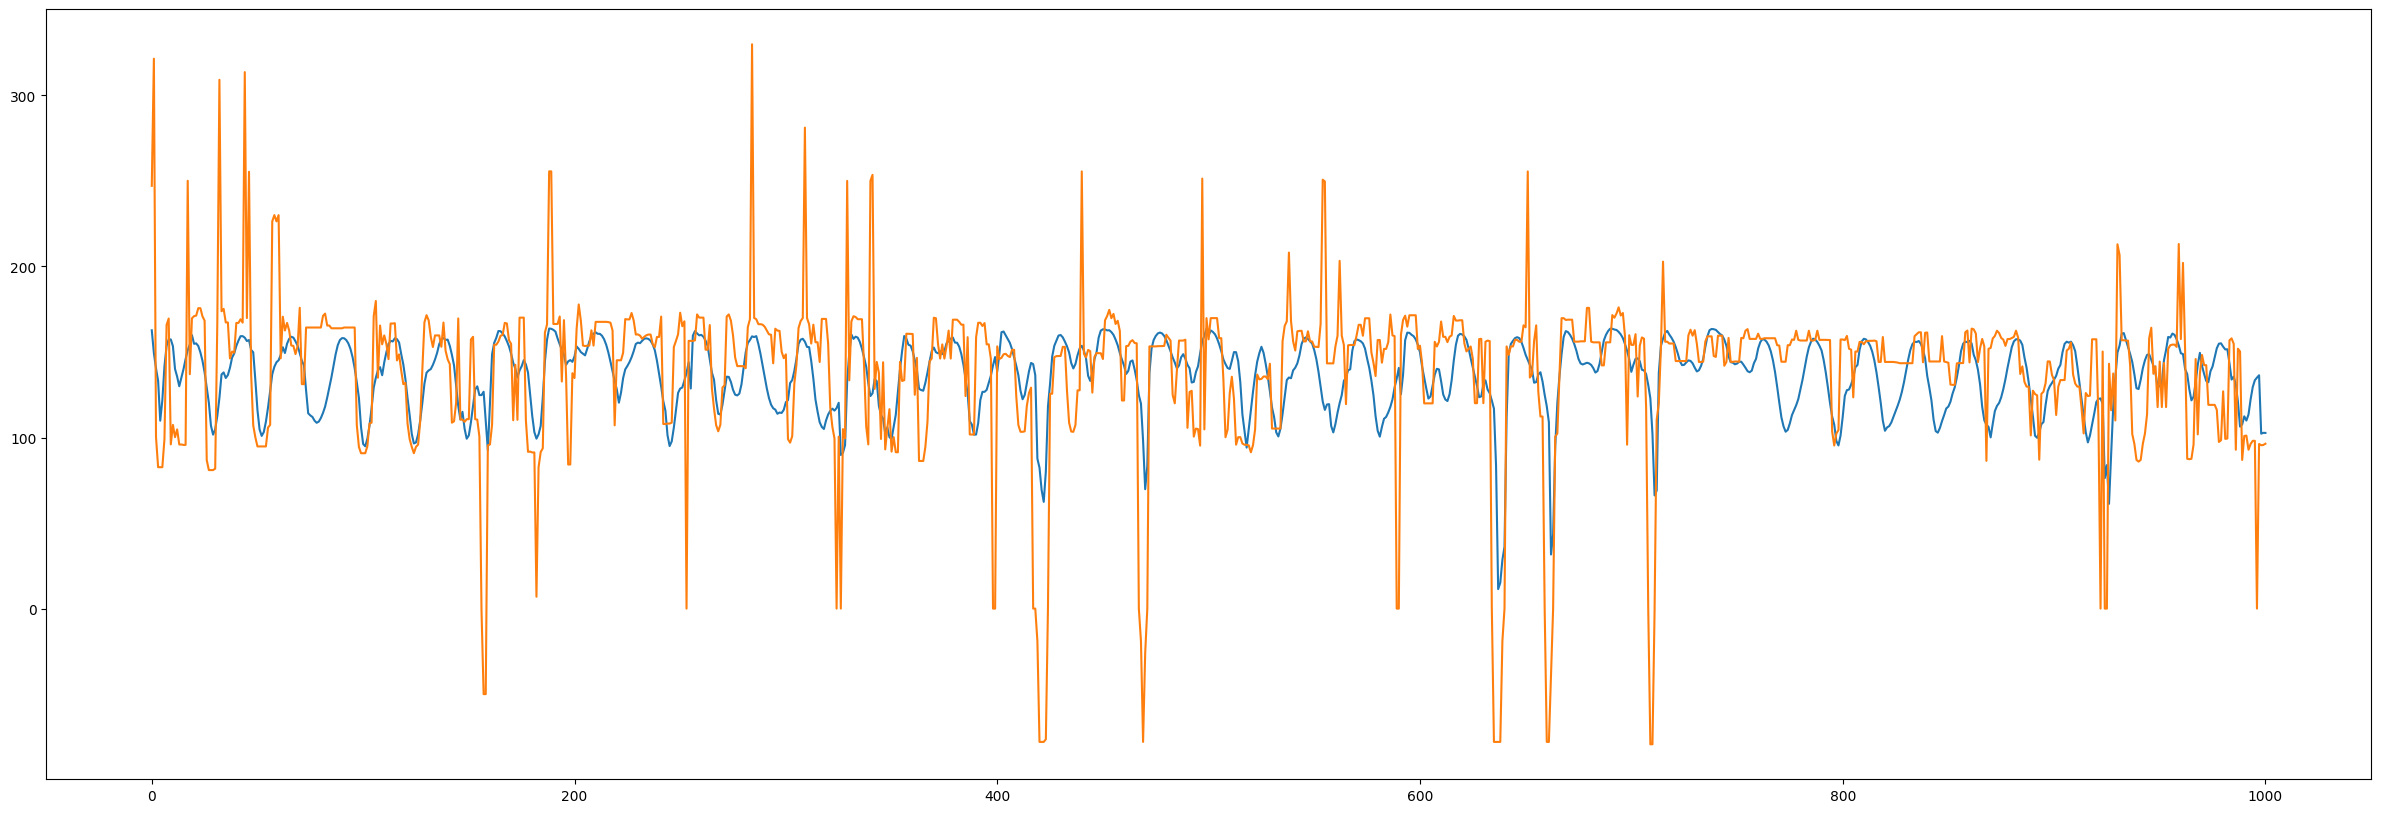

In [38]:
plt.figure(figsize=(30, 10))
plt.plot(preds, label='predic')
plt.plot(real, label='real price')

In [ ]:
real = []
preds = []

for idx, (X, y) in enumerate(test_loader):
    if idx < 180: continue    
    inputs = X
    
    outputs = model(inputs)
    
    pred = float(outputs)
    y = float(y)

    real.append(y)
    preds.append(pred)
    
    if idx == 226:
        break

In [ ]:
plt.plot(preds)
plt.plot(real)